In [1]:
import numpy as np
from load_mnist import load_mnist
import matplotlib.pyplot as plt
import numpy as np
import time


In [2]:
# Load the data
X_train, Y_train, X_test, Y_test = load_mnist()

Extracting MNIST.zip
Archive:  ../../datasets/MNIST.zip
   creating: ./MNIST/
 extracting: ./MNIST/readme.txt      
   creating: ./MNIST/Test/
   creating: ./MNIST/Train/
   creating: ./MNIST/Test/2/
 extracting: ./MNIST/Test/2/0654.png  
 extracting: ./MNIST/Test/2/0673.png  
 extracting: ./MNIST/Test/2/0659.png  
 extracting: ./MNIST/Test/2/0711.png  
 extracting: ./MNIST/Test/2/0718.png  
 extracting: ./MNIST/Test/2/0771.png  
 extracting: ./MNIST/Test/2/0009.png  
 extracting: ./MNIST/Test/2/0820.png  
 extracting: ./MNIST/Test/2/0284.png  
  inflating: ./MNIST/Test/2/0090.png  
 extracting: ./MNIST/Test/2/0998.png  
 extracting: ./MNIST/Test/2/0845.png  
 extracting: ./MNIST/Test/2/0256.png  
 extracting: ./MNIST/Test/2/1027.png  
 extracting: ./MNIST/Test/2/0809.png  
 extracting: ./MNIST/Test/2/0019.png  
  inflating: ./MNIST/Test/2/0906.png  
 extracting: ./MNIST/Test/2/0578.png  
  inflating: ./MNIST/Test/2/0778.png  
  inflating: ./MNIST/Test/2/0016.png  
 extracting: ./MNIST

In [4]:
print("X_train.shape = ", X_train.shape)
print("Y_train.shape = ", Y_train.shape)
print("X_test.shape = ", X_test.shape)
print("Y_test.shape = ", Y_test.shape)

X_train.shape =  (60000, 784)
Y_train.shape =  (60000, 10)
X_test.shape =  (10000, 784)
Y_test.shape =  (10000, 10)


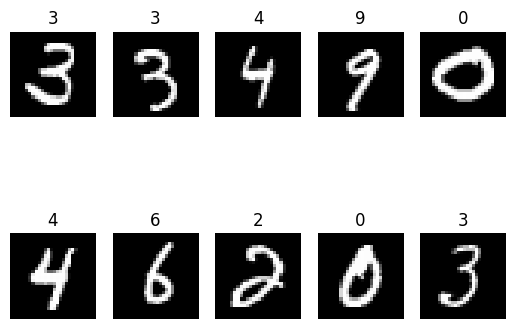

In [5]:
idx = np.arange(X_train.shape[0])
np.random.shuffle(idx)
X_train = X_train[idx]
Y_train = Y_train[idx]

# Plot the first 10 images in the training set
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.title(np.argmax(Y_train[i]))
    plt.axis('off')
plt.show()


In [20]:


class SoftmaxRegression(object):
    def __init__(self, eta=0.05, epochs=1000,
                 l2=0.5,
                 minibatches=100,
                 random_seed=None):

        self.eta = eta
        self.epochs = epochs
        self.l2 = l2
        self.minibatches = minibatches
        self.random_seed = random_seed
        self.cost_train_ = []
        self.cost_test_  = []
        self.acc_train_  = []
        self.acc_test_   = []

    def fit(self, X, y, X_test, y_test):
        if self.random_seed is not None:
            np.random.seed(self.random_seed)

        n_features = X.shape[1]
        n_classes = y.shape[1]

        # initialize weights and bias
        self._init_params(
            weights_shape=(n_features, n_classes),
            bias_shape=(n_classes,),
            random_seed=self.random_seed)

        # compute cost of the whole epoch before training
        cost_train = self.compute_cost(X, y)
        self.cost_train_.append(cost_train)
        cost_test = self.compute_cost(X_test, y_test)
        self.cost_test_.append(cost_test)

        acc_train = self.accuracy(X, y)
        self.acc_train_.append(acc_train)
        acc_test = self.accuracy(X_test, y_test)
        self.acc_test_.append(acc_test)
        print(f'Epoch: {0} | Lost: {cost_train:.4f} | Train Acc.: {acc_train:.3f}% | Test Acc.: {acc_test:.3f}%')

        for epoch in range(self.epochs):
            for idx in self._yield_minibatches_idx(
                    n_batches=self.minibatches,
                    data_ary=y,
                    shuffle=True):

                # net_input, softmax and diff -> n_samples x n_classes:
                net = self.linear_forward(X[idx], self.w_, self.b_)
                softm = self.softmax(net)
                diff = softm - y[idx]

                # gradient -> n_features x n_classes
                dw = np.dot(X[idx].T, diff) / X[idx].shape[0]
                db = np.sum(diff, axis=0) / X[idx].shape[0]
                
                # update in opp. direction of the cost gradient
                self.update_parameters(dw, db)

            # compute cost of the whole epoch after training
            cost_train = self.compute_cost(X, y)
            self.cost_train_.append(cost_train)
            cost_test = self.compute_cost(X_test, y_test)
            self.cost_test_.append(cost_test)

            acc_train = self.accuracy(X, y)
            self.acc_train_.append(acc_train)
            acc_test = self.accuracy(X_test, y_test)
            self.acc_test_.append(acc_test)
            print(f'Epoch: {epoch+1} | Lost: {cost_train:.4f} | Train Acc.: {acc_train:.3f}% | Test Acc.: {acc_test:.3f}%')

        return self

    def accuracy(self, X, y_target):
        y_pred = self.predict(X)
        return 100.0 * np.sum(y_pred==y_target.argmax(axis=1))/len(X)

    def compute_cost(self, X, y):
        net = self.linear_forward(X, self.w_, self.b_)
        softm = self.softmax(net)
        cross_ent = self._cross_entropy(output=softm, y_target=y)
        cost = self._cost(cross_ent)
        return cost

    def update_parameters(self, dw, db):
        self.w_ -= self.eta * ( dw +
                     self.l2 * self.w_)
        self.b_ -= self.eta * db
        return self
 
    def predict(self, X):
        net = self.linear_forward(X, self.w_, self.b_)
        softm = self.softmax(net)
        return softm.argmax(axis=1)

    def linear_forward(self, X, W, b):
        return X.dot(W) + b

    def softmax(self, z):
        exp = np.exp(z - np.max(z, axis=1, keepdims=True))
    
        # Calculating softmax for all examples.
        for i in range(len(z)):
            exp[i] /= np.sum(exp[i])
        
        return exp

    def _cross_entropy(self, output, y_target):
        return - np.sum(np.log(output + 1e-15) * (y_target), axis=1) #+ 1e-15 to avoid log(0)

    def _cost(self, cross_entropy):
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        cross_entropy = cross_entropy + L2_term
        return 0.5 * np.mean(cross_entropy)
    
    def _init_params(self, weights_shape, bias_shape=(1,),
                     scale=0.01, random_seed=None):
        """Initialize weight coefficients."""
        if random_seed:
            np.random.seed(random_seed)
        self.w_ = np.random.normal(loc=0.0, scale=scale, size=weights_shape)
        self.b_ = np.zeros(shape=bias_shape)
        return self   
    
    def _yield_minibatches_idx(self, n_batches, data_ary, shuffle=True):
            indices = np.arange(data_ary.shape[0])

            if shuffle:
                indices = np.random.permutation(indices)
            if n_batches > 1:
                remainder = data_ary.shape[0] % n_batches

                if remainder:
                    minis = np.array_split(indices[:-remainder], n_batches)
                    minis[-1] = np.concatenate((minis[-1], indices[-remainder:]), axis=0)
                else:
                    minis = np.array_split(indices, n_batches)
            else:
                minis = (indices,)

            for idx_batch in minis:
                yield idx_batch


In [45]:
sr = SoftmaxRegression(eta=0.3, epochs=100, minibatches=200, l2=0, random_seed=2)

start_time = time.time()
sr.fit(X_train, Y_train, X_test, Y_test)
end_time = time.time()
print(f'Training Time: {end_time - start_time:.2f} sec')


Epoch: 0 | Lost: 1.1571 | Train Acc.: 9.462% | Test Acc.: 9.220%
Epoch: 1 | Lost: 0.1899 | Train Acc.: 89.688% | Test Acc.: 90.230%
Epoch: 2 | Lost: 0.1695 | Train Acc.: 90.595% | Test Acc.: 91.070%
Epoch: 3 | Lost: 0.1603 | Train Acc.: 91.075% | Test Acc.: 91.480%
Epoch: 4 | Lost: 0.1543 | Train Acc.: 91.437% | Test Acc.: 91.630%
Epoch: 5 | Lost: 0.1502 | Train Acc.: 91.645% | Test Acc.: 91.850%
Epoch: 6 | Lost: 0.1474 | Train Acc.: 91.802% | Test Acc.: 91.960%
Epoch: 7 | Lost: 0.1457 | Train Acc.: 91.935% | Test Acc.: 92.060%
Epoch: 8 | Lost: 0.1438 | Train Acc.: 91.948% | Test Acc.: 92.090%
Epoch: 9 | Lost: 0.1418 | Train Acc.: 92.037% | Test Acc.: 92.110%
Epoch: 10 | Lost: 0.1412 | Train Acc.: 92.045% | Test Acc.: 92.100%
Epoch: 11 | Lost: 0.1395 | Train Acc.: 92.182% | Test Acc.: 92.130%
Epoch: 12 | Lost: 0.1382 | Train Acc.: 92.335% | Test Acc.: 92.150%
Epoch: 13 | Lost: 0.1378 | Train Acc.: 92.408% | Test Acc.: 92.120%
Epoch: 14 | Lost: 0.1367 | Train Acc.: 92.353% | Test Acc.: 

In [46]:
idx = np.arange(X_test.shape[0])
np.random.shuffle(idx)
X_test_shuffled = X_test[idx]
Y_test_shuffled = Y_test[idx]

y_pred=sr.predict(X_test_shuffled)

print('Test accuracy: %.2f%%' % (sr.accuracy(X_test_shuffled, Y_test_shuffled)))

Test accuracy: 92.54%


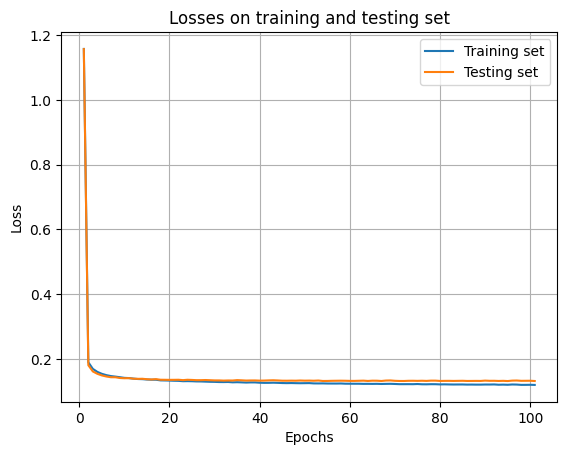

In [55]:
fig = plt.figure()
plt.plot(range(1, len(sr.cost_train_) + 1), sr.cost_train_, label='Training set')

plt.plot(range(1, len(sr.cost_test_) + 1), sr.cost_test_, label='Testing set')
plt.title('Losses on training and testing set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()
fig.savefig('losses_softmax.png')

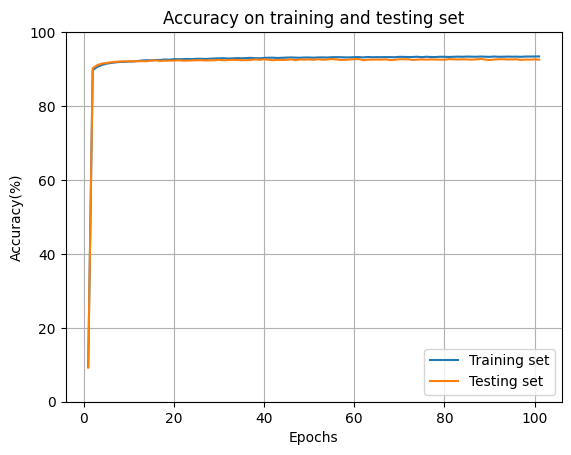

In [61]:
fig = plt.figure()
plt.plot(range(1, len(sr.acc_train_) + 1), sr.acc_train_, label='Training set')
plt.plot(range(1, len(sr.acc_test_) + 1), sr.acc_test_, label='Testing set')
plt.title('Accuracy on training and testing set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.ylim(0, 100)
plt.legend(loc='lower right')
plt.grid()
plt.show()
fig.savefig('accuracy_softmax.png')

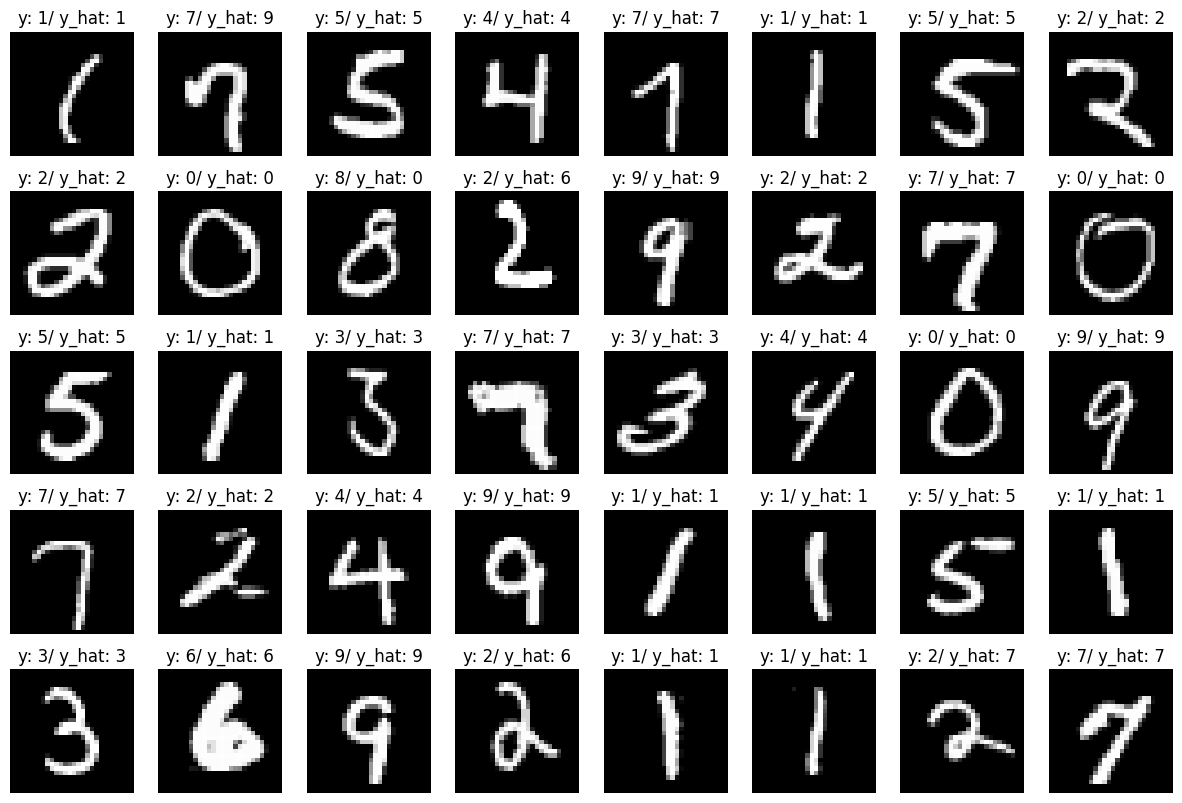

<Figure size 640x480 with 0 Axes>

In [44]:
fig = plt.figure(figsize=(15,10))
count= 0
for i in range(40):  
    ax = fig.add_subplot(5, 8, i+1)
    ax.imshow(X_test_shuffled[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    
    ax.set_title('y: {y}/ y_hat: {y_hat}'
                 .format(y=Y_test_shuffled[i].argmax(), y_hat=y_pred[i]))
    if Y_test_shuffled[i].argmax() == y_pred[i]:
        count = count + 1
    plt.axis('off')
plt.show()
plt.savefig('mnist.png')

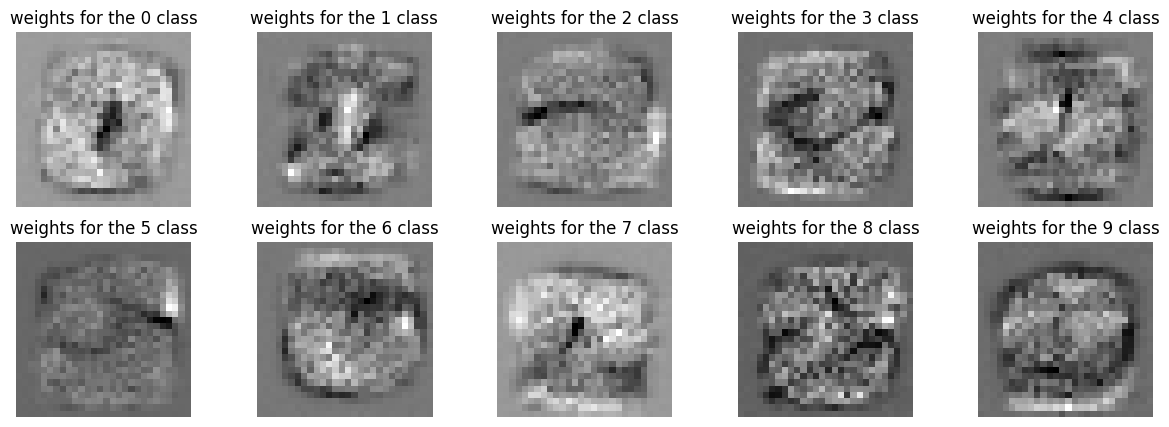

In [51]:
fig = plt.figure(figsize=(15,5))
for i in range(10):  
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(sr.w_[:,i].reshape(28,28), cmap=plt.get_cmap('gray'))
    ax.set_title('weights for the {i} class'.format(i=i))
    plt.axis('off')
plt.show()

fig.savefig('softmax_weights.png', bbox_inches='tight')
